In [30]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy

import numpy as np
from scipy import ndimage

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from unagi import config
from unagi import hsc
from unagi import mask
from unagi import plotting
from unagi.task import hsc_cutout, hsc_tricolor

pdr2 = hsc.Hsc(dr='pdr2', rerun='pdr2_wide')

# Get table list from /Users/song/Dropbox/work/project/unagi/unagi/data/pdr2_wide/pdr2_wide_tables.fits


In [3]:
from caterpillar import catalog

## Test the Dynamical Cutout Size for HSC Dwarf Candidates

In [11]:
# Remove all the `isnull` columns
# Only needs to do this once

# cat_g09 = catalog.remove_is_null(os.path.join(merian_dir, 'catalog', 'Broadcut_GAMA09H.fits'), return_data=True)

Reading the data....
Saving data to None ...


In [41]:
merian_dir = '/Users/song/Downloads/merian/'

pdr2_g09_cat = os.path.join(merian_dir, 'catalog', 'Broadcut_GAMA09H.fits')
pdr2_g09 = Table.read(pdr2_g09_cat)

print(len(pdr2_g09))

3049545


In [42]:
pdr2_g09 = catalog.moments_to_shape(pdr2_g09, shape_type='i_sdss_shape', update=True)
pdr2_g09 = catalog.moments_to_shape(pdr2_g09, shape_type='i_cmodel_exp_ellipse', update=True)
pdr2_g09 = catalog.moments_to_shape(pdr2_g09, shape_type='i_cmodel_ellipse', update=True)
pdr2_g09 = catalog.moments_to_shape(pdr2_g09, shape_type='r_cmodel_exp_ellipse', update=True)
pdr2_g09 = catalog.moments_to_shape(pdr2_g09, shape_type='r_cmodel_ellipse', update=True)

#### Filter through bright star mask

In [8]:
mask_dir = '/Users/song/astro1/hsc/bright_star_new/'

pdr2_g09_bsm = catalog.filter_through_bright_star_mask(pdr2_g09_cat, mask_dir)

In [43]:
pdr2_g09_bsm = Table.read(os.path.join(merian_dir, 'catalog', 'Broadcut_GAMA09H_bsm.fits'))

print(len(pdr2_g09_bsm))

1906179


In [44]:
pdr2_g09_bsm = catalog.moments_to_shape(pdr2_g09_bsm, shape_type='i_sdss_shape', update=True)
pdr2_g09_bsm = catalog.moments_to_shape(pdr2_g09_bsm, shape_type='i_cmodel_exp_ellipse', update=True)
pdr2_g09_bsm = catalog.moments_to_shape(pdr2_g09_bsm, shape_type='i_cmodel_ellipse', update=True)
pdr2_g09_bsm = catalog.moments_to_shape(pdr2_g09_bsm, shape_type='r_cmodel_exp_ellipse', update=True)
pdr2_g09_bsm = catalog.moments_to_shape(pdr2_g09_bsm, shape_type='r_cmodel_ellipse', update=True)

#### Get the objects within the bright star masks

In [45]:
pdr2_g09_msk = catalog.filter_through_bright_star_mask(
    pdr2_g09_cat, mask_dir, filter_type='inside', output_suffix='masked')

In [50]:
print(len(pdr2_g09_msk))

pdr2_g09_msk = catalog.moments_to_shape(pdr2_g09_msk, shape_type='i_sdss_shape', update=True)
pdr2_g09_msk = catalog.moments_to_shape(pdr2_g09_msk, shape_type='i_cmodel_exp_ellipse', update=True)
pdr2_g09_msk = catalog.moments_to_shape(pdr2_g09_msk, shape_type='i_cmodel_ellipse', update=True)
pdr2_g09_msk = catalog.moments_to_shape(pdr2_g09_msk, shape_type='r_cmodel_exp_ellipse', update=True)
pdr2_g09_msk = catalog.moments_to_shape(pdr2_g09_msk, shape_type='r_cmodel_ellipse', update=True)

950602


#### Spatial distributions of objects

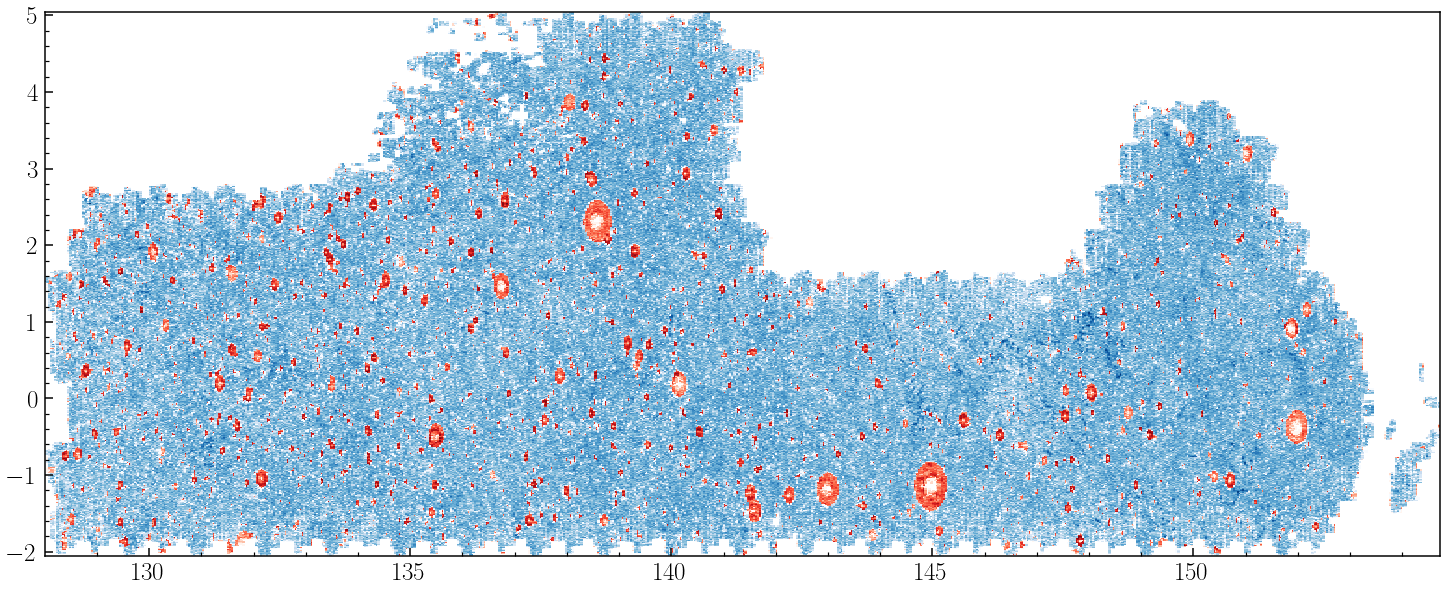

In [48]:
plt.figure(figsize=(25, 10))

_ = plt.hist2d(pdr2_g09['ra'], pdr2_g09['dec'], bins=(750, 550), norm=mpl.colors.LogNorm(),
               cmap='Reds', edgecolor='none')

_ = plt.hist2d(pdr2_g09_bsm['ra'], pdr2_g09_bsm['dec'], bins=(750, 550), alpha=1.0, 
               norm=mpl.colors.LogNorm(), cmap='Blues', edgecolor='none')

In [52]:
aper_mask = (
    (pdr2_g09_bsm['g_undeblended_convolvedflux_2_15_flux'] > 0.) & 
    (pdr2_g09_bsm['r_undeblended_convolvedflux_2_15_flux'] > 0.) & 
    (pdr2_g09_bsm['i_undeblended_convolvedflux_2_15_flux'] > 0.) & 
    (pdr2_g09_bsm['z_undeblended_convolvedflux_2_15_flux'] > 0.) & 
    (pdr2_g09_bsm['y_undeblended_convolvedflux_2_15_flux'] > 0.) & 
    (pdr2_g09_bsm['g_undeblended_convolvedflux_3_20_flux'] > 0.) & 
    (pdr2_g09_bsm['r_undeblended_convolvedflux_3_20_flux'] > 0.) & 
    (pdr2_g09_bsm['i_undeblended_convolvedflux_3_20_flux'] > 0.) & 
    (pdr2_g09_bsm['z_undeblended_convolvedflux_3_20_flux'] > 0.) & 
    (pdr2_g09_bsm['y_undeblended_convolvedflux_3_20_flux'] > 0.)
)

size_mask = (
    (np.log10(pdr2_g09_bsm['i_cmodel_exp_ellipse_r']) >= -0.8) & 
    (np.log10(pdr2_g09_bsm['r_cmodel_exp_ellipse_r']) >= -0.8) &
    (np.log10(pdr2_g09_bsm['i_cmodel_exp_ellipse_r']) <= 0.75) &
    (np.log10(pdr2_g09_bsm['i_cmodel_exp_ellipse_r']) < -0.25 * pdr2_g09_bsm['i_cmodel_mag'] + 6.2) 
)

frac_mask = (
    (pdr2_g09_bsm['i_undeblended_convolvedflux_2_15_flux'] / pdr2_g09_bsm['i_cmodel_flux'] <= 1.0) &
    (pdr2_g09_bsm['i_psf_flux'] / pdr2_g09_bsm['i_cmodel_flux'] <= 0.90) &
    (pdr2_g09_bsm['i_undeblended_convolvedflux_2_15_flux'] / pdr2_g09_bsm['i_cmodel_flux'] >= 0.13 * pdr2_g09_bsm['i_cmodel_mag'] - 2.65) 
)


rz_aper_g09 = (-2.5 * np.log10(pdr2_g09_bsm['r_undeblended_convolvedflux_3_20_flux'] / 
                               pdr2_g09_bsm['z_undeblended_convolvedflux_3_20_flux']))
gi_aper_g09 = (-2.5 * np.log10(pdr2_g09_bsm['g_undeblended_convolvedflux_3_20_flux'] / 
                               pdr2_g09_bsm['i_undeblended_convolvedflux_3_20_flux']))
gr_aper_g09 = (-2.5 * np.log10(pdr2_g09_bsm['g_undeblended_convolvedflux_3_20_flux'] / 
                               pdr2_g09_bsm['r_undeblended_convolvedflux_3_20_flux']))
iy_aper_g09 = (-2.5 * np.log10(pdr2_g09_bsm['i_undeblended_convolvedflux_3_20_flux'] / 
                               pdr2_g09_bsm['y_undeblended_convolvedflux_3_20_flux']))

aper_color_mask = (
    (rz_aper_g09 <= 0.75) & (rz_aper_g09 >= 0.0) & 
    (rz_aper_g09 >= 0.13 * pdr2_g09_bsm['i_cmodel_mag'] - 2.8) &
    (gi_aper_g09 <= 1.5) & (gi_aper_g09 >= 0.0) & 
    (gi_aper_g09 >= 0.25 * pdr2_g09_bsm['i_cmodel_mag'] - 5.4) &
    (rz_aper_g09 <= 0.63 * gr_aper_g09 + 0.25) &
    (iy_aper_g09 <= 0.35 * gi_aper_g09 + 0.12) & 
    (iy_aper_g09 >= -0.15)
)

<ipython-input-52-14d8033300c4>:28: RuntimeWarning: invalid value encountered in log10
  rz_aper_g09 = (-2.5 * np.log10(pdr2_g09_bsm['r_undeblended_convolvedflux_3_20_flux'] /
<ipython-input-52-14d8033300c4>:30: RuntimeWarning: invalid value encountered in log10
  gi_aper_g09 = (-2.5 * np.log10(pdr2_g09_bsm['g_undeblended_convolvedflux_3_20_flux'] /
<ipython-input-52-14d8033300c4>:32: RuntimeWarning: invalid value encountered in log10
  gr_aper_g09 = (-2.5 * np.log10(pdr2_g09_bsm['g_undeblended_convolvedflux_3_20_flux'] /
<ipython-input-52-14d8033300c4>:34: RuntimeWarning: invalid value encountered in log10
  iy_aper_g09 = (-2.5 * np.log10(pdr2_g09_bsm['i_undeblended_convolvedflux_3_20_flux'] /


In [53]:
mask = size_mask & aper_mask & frac_mask & aper_color_mask
print(mask.sum() / len(pdr2_g09_bsm))

mask = aper_mask

0.5178967977299089


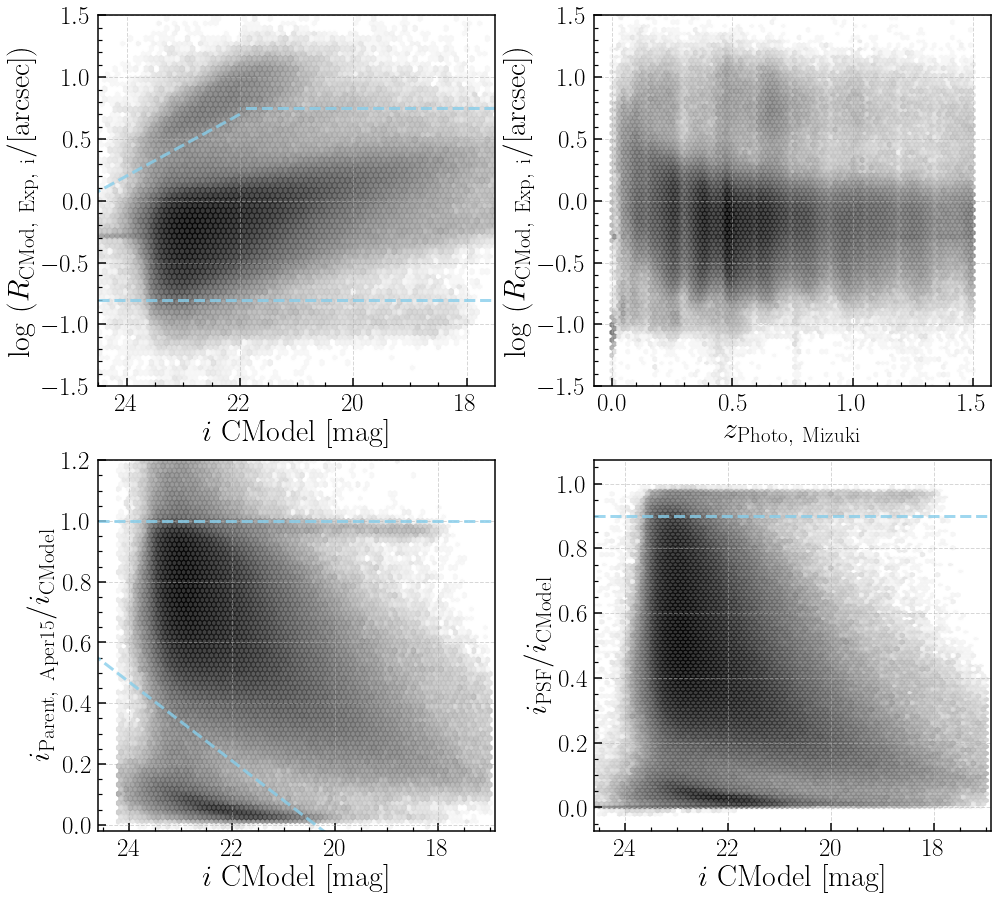

In [55]:
fig, axs = plt.subplots(2, 2, figsize=(16, 15))
plt.subplots_adjust(hspace=0.20, wspace=0.25)

# Magnitude-Size
ax1 = axs[0, 0]

_ = ax1.hexbin(
    pdr2_g09_bsm['i_cmodel_mag'][mask], 
    np.log10(pdr2_g09_bsm['i_cmodel_exp_ellipse_r'][mask]), 
    extent=(17.5, 24.8, -2.5, 1.6), cmap='Greys', bins='log', gridsize=(80, 50),
    alpha=0.8)

#_ = ax1.scatter(
#    pdr2_match_bsm['i_cmodel_mag'], np.log10(pdr2_match_bsm['i_cmodel_exp_ellipse_r']),
#    s=60, alpha=0.8, facecolor='orangered', edgecolor='w')

ax1.set_xlim(24.5, 17.5)
ax1.set_ylim(-1.5, 1.5)

ax1.set_xlabel(r'$i\ \rm CModel\ [mag]$', fontsize=30)
ax1.set_ylabel(r'$\log\ (R_{\rm CMod,\ Exp,\ i}/[\rm arcsec])$', fontsize=30)

# Photo-z-Size
ax2 = axs[0, 1]

_ = ax2.hexbin(
    pdr2_g09_bsm['photoz_best'][mask], 
    np.log10(pdr2_g09_bsm['i_cmodel_exp_ellipse_r'][mask]), 
    extent=(0, 1.5, -1.5, 1.6), cmap='Greys', bins='log', gridsize=(80, 50),
    alpha=0.8)

#_ = ax2.scatter(
#    pdr2_match_bsm['photoz_best'], np.log10(pdr2_match_bsm['i_cmodel_exp_ellipse_r']),
#    s=60, alpha=0.8, facecolor='orangered', edgecolor='w')

#ax2.set_xlim(23.5, 18.0)
ax2.set_ylim(-1.5, 1.5)

ax2.set_xlabel(r'$z_{\rm Photo,\ Mizuki}$', fontsize=30)
ax2.set_ylabel(r'$\log\ (R_{\rm CMod,\ Exp,\ i}/[\rm arcsec])$', fontsize=30)

# Photo-z-Size
ax3 = axs[1, 0]

_ = ax3.hexbin(
    pdr2_g09_bsm['i_cmodel_mag'][mask], 
    (pdr2_g09_bsm['i_undeblended_convolvedflux_2_15_flux'][mask] / pdr2_g09_bsm['i_cmodel_flux'][mask]), 
    extent=(17.0, 24.2, -0.02, 1.5), cmap='Greys', bins='log', gridsize=(80, 50), alpha=0.8)

#_ = ax3.scatter(
#    pdr2_match_bsm['i_cmodel_mag'], 
#    (pdr2_match_bsm['i_undeblended_convolvedflux_2_15_flux'] / pdr2_match_bsm['i_cmodel_flux']), 
#    s=60, alpha=0.8, facecolor='orangered', edgecolor='w')

ax3.set_xlim(24.6, 16.9)
ax3.set_ylim(-0.02, 1.2)

ax3.set_xlabel(r'$i\ \rm CModel\ [mag]$', fontsize=30)
ax3.set_ylabel(r'$i_{\rm Parent,\ Aper15} / i_{\rm CModel}$', fontsize=30)

# Photo-z-Size
ax4 = axs[1, 1]

_ = ax4.hexbin(
    -2.5 * np.log10(pdr2_g09_bsm['i_cmodel_flux'][mask]) + 31.4, 
    pdr2_g09_bsm['i_psf_flux'][mask] / pdr2_g09_bsm['i_cmodel_flux'][mask], 
    extent=(17.0, 24.9, -0.02, 1.02), cmap='Greys', bins='log', gridsize=(80, 50), alpha=0.8)

#_ = ax4.scatter(
#    -2.5 * np.log10(pdr2_match_bsm['i_cmodel_flux']) + 31.4, 
#    pdr2_match_bsm['i_psf_flux'] / pdr2_match_bsm['i_cmodel_flux'], 
#    s=60, alpha=0.8, facecolor='orangered', edgecolor='w')

ax4.set_xlim(24.6, 16.9)
#ax4.set_ylim(-1.5, 1.5)

ax4.set_xlabel(r'$i\ \rm CModel\ [mag]$', fontsize=30)
ax4.set_ylabel(r'$i_{\rm PSF} / i_{\rm CModel}$', fontsize=30)

# -------------------------------- #
x = np.linspace(22.0, 25.0, 100)
y = -0.25 * x + 6.2
ax1.plot(x, y, linestyle='--', linewidth=3.0, alpha=0.8, c='skyblue')
ax1.axhline(-0.8, linestyle='--', linewidth=3.0, alpha=0.8, c='skyblue')
ax1.plot([17.5, 22.0], [0.75, 0.75], linestyle='--', linewidth=3.0, alpha=0.8, c='skyblue')

ax3.axhline(1.0, linestyle='--', linewidth=3.0, alpha=0.8, c='skyblue')
x = np.linspace(18.0, 25.2, 100)
y = 0.13 * x - 2.65
ax3.plot(x, y, linestyle='--', linewidth=3.0, alpha=0.8, c='skyblue')

ax4.axhline(0.9, linestyle='--', linewidth=3.0, alpha=0.8, c='skyblue')

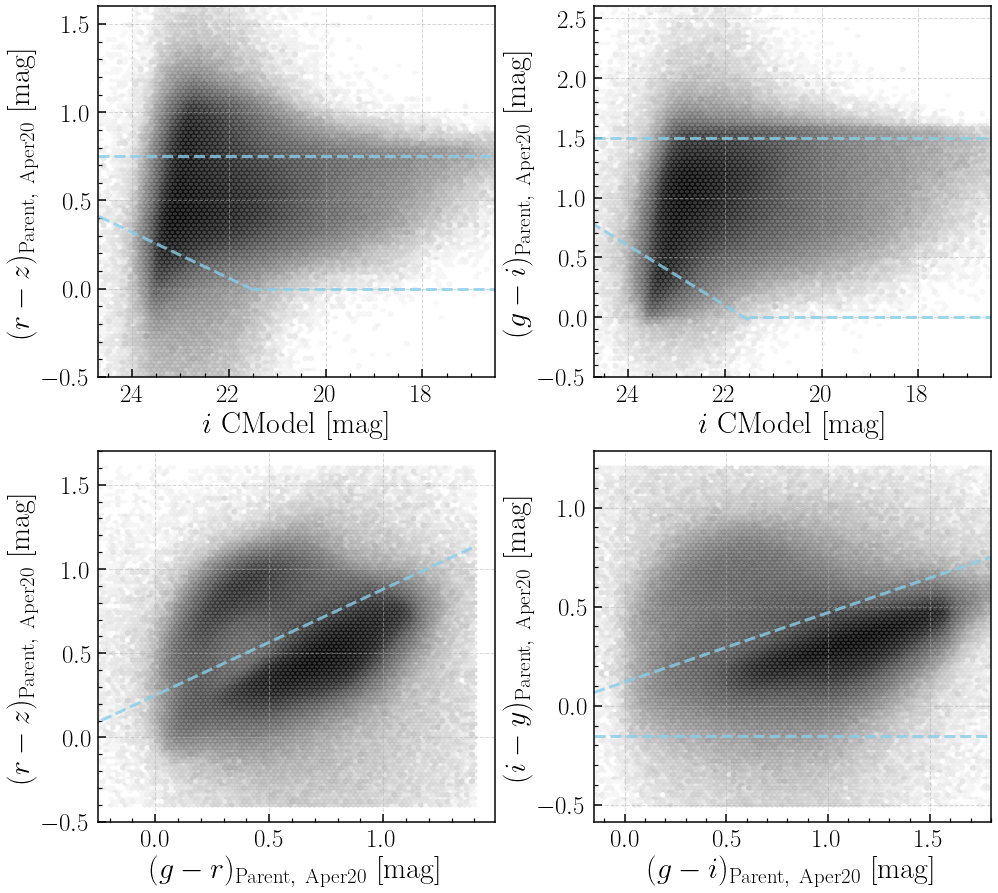

In [58]:
fig, axs = plt.subplots(2, 2, figsize=(16, 15))
plt.subplots_adjust(hspace=0.20, wspace=0.25)

# CModel mag v.s. (r-z) aperture
ax1 = axs[0, 0]

i_aper_g09 = -2.5 * np.log10(pdr2_g09_bsm['i_cmodel_flux'][mask]) + 31.4
rz_aper_g09 = (-2.5 * np.log10(pdr2_g09_bsm['r_undeblended_convolvedflux_3_20_flux'][mask] / 
                               pdr2_g09_bsm['z_undeblended_convolvedflux_3_20_flux'][mask]))


_ = ax1.hexbin(
    i_aper_g09, rz_aper_g09,
    extent=(16.4, 25.2, -0.5, 1.6), cmap='Greys', bins='log', gridsize=(80, 50),
    alpha=0.8)

#i_aper_match = -2.5 * np.log10(pdr2_match_bsm['i_cmodel_flux']) + 31.4
#rz_aper_match = (-2.5 * np.log10(pdr2_match_bsm['r_undeblended_convolvedflux_3_20_flux'] / 
#                                 pdr2_match_bsm['z_undeblended_convolvedflux_3_20_flux']))

#_ = ax1.scatter(
#    i_aper_match, rz_aper_match,
#    s=60, alpha=0.8, facecolor='orangered', edgecolor='w')

ax1.set_xlim(24.7, 16.5)
ax1.set_ylim(-0.5, 1.6)

ax1.set_xlabel(r'$i\ \rm CModel\ [mag]$', fontsize=30)
ax1.set_ylabel(r'$(r-z)_{\rm Parent,\ Aper20}\ [\rm mag]$', fontsize=30)

# CModel mag v.s. (g-i) aperture
ax2 = axs[0, 1]

i_aper_g09 = -2.5 * np.log10(pdr2_g09_bsm['i_cmodel_flux'][mask]) + 31.4
gi_aper_g09 = (-2.5 * np.log10(pdr2_g09_bsm['g_undeblended_convolvedflux_3_20_flux'][mask] / 
                               pdr2_g09_bsm['i_undeblended_convolvedflux_3_20_flux'][mask]))

_ = ax2.hexbin(
    i_aper_g09, gi_aper_g09,
    extent=(16.4, 25.2, -0.5, 2.6), cmap='Greys', bins='log', gridsize=(80, 50),
    alpha=0.8)

#i_aper_match = -2.5 * np.log10(pdr2_match_bsm['i_cmodel_flux']) + 31.4
#gi_aper_match = (-2.5 * np.log10(pdr2_match_bsm['g_undeblended_convolvedflux_3_20_flux'] / 
#                                 pdr2_match_bsm['i_undeblended_convolvedflux_3_20_flux']))

#_ = ax2.scatter(
#    i_aper_match, gi_aper_match,
#    s=60, alpha=0.8, facecolor='orangered', edgecolor='w')

ax2.set_xlim(24.7, 16.5)
ax2.set_ylim(-0.5, 2.6)

ax2.set_xlabel(r'$i\ \rm CModel\ [mag]$', fontsize=30)
ax2.set_ylabel(r'$(g-i)_{\rm Parent,\ Aper20}\ [\rm mag]$', fontsize=30)


# CModel mag v.s. (i-y) aperture color
ax3 = axs[1, 0]

i_aper_g09 = -2.5 * np.log10(pdr2_g09_bsm['i_cmodel_flux'][mask]) + 31.4
gr_aper_g09 = (-2.5 * np.log10(pdr2_g09_bsm['g_undeblended_convolvedflux_3_20_flux'][mask] / 
                               pdr2_g09_bsm['r_undeblended_convolvedflux_3_20_flux'][mask]))
rz_aper_g09 = (-2.5 * np.log10(pdr2_g09_bsm['r_undeblended_convolvedflux_3_20_flux'][mask] / 
                               pdr2_g09_bsm['z_undeblended_convolvedflux_3_20_flux'][mask]))

_ = ax3.hexbin(
    gr_aper_g09, rz_aper_g09,
    extent=(-0.3, 1.4, -0.4, 1.6), cmap='Greys', bins='log', gridsize=(80, 50),
    alpha=0.8)

#gr_aper_match = (-2.5 * np.log10(pdr2_match_bsm['g_undeblended_convolvedflux_3_20_flux'] / 
#                                 pdr2_match_bsm['r_undeblended_convolvedflux_3_20_flux']))
#rz_aper_match = (-2.5 * np.log10(pdr2_match_bsm['r_undeblended_convolvedflux_3_20_flux'] / 
#                                 pdr2_match_bsm['z_undeblended_convolvedflux_3_20_flux']))

#_ = ax3.scatter(
#    gr_aper_match, rz_aper_match,
#    s=60, alpha=0.8, facecolor='orangered', edgecolor='w')

ax3.set_xlim(-0.25, 1.49)

ax3.set_xlabel(r'$(g-r)_{\rm Parent,\ Aper20}\ [\rm mag]$', fontsize=30)
ax3.set_ylabel(r'$(r-z)_{\rm Parent,\ Aper20}\ [\rm mag]$', fontsize=30)

# CModel mag v.s. (i-y) aperture color
ax4 = axs[1, 1]

i_aper_g09 = -2.5 * np.log10(pdr2_g09_bsm['i_cmodel_flux'][mask]) + 31.4
gi_aper_g09 = (-2.5 * np.log10(pdr2_g09_bsm['g_undeblended_convolvedflux_3_20_flux'][mask] / 
                               pdr2_g09_bsm['i_undeblended_convolvedflux_3_20_flux'][mask]))
iy_aper_g09 = (-2.5 * np.log10(pdr2_g09_bsm['i_undeblended_convolvedflux_3_20_flux'][mask] / 
                               pdr2_g09_bsm['y_undeblended_convolvedflux_3_20_flux'][mask]))

_ = ax4.hexbin(
    gi_aper_g09, iy_aper_g09,
    extent=(-0.2, 1.8, -0.5, 1.2), cmap='Greys', bins='log', gridsize=(80, 50),
    alpha=0.8)

#gi_aper_match = (-2.5 * np.log10(pdr2_match_bsm['g_undeblended_convolvedflux_3_20_flux'] / 
#                                 pdr2_match_bsm['i_undeblended_convolvedflux_3_20_flux']))
#iy_aper_match = (-2.5 * np.log10(pdr2_match_bsm['i_undeblended_convolvedflux_3_20_flux'] / 
#                                 pdr2_match_bsm['y_undeblended_convolvedflux_3_20_flux']))

#_ = ax4.scatter(
#    gi_aper_match, iy_aper_match,
#    s=60, alpha=0.8, facecolor='orangered', edgecolor='w')

ax4.set_xlim(-0.15, 1.8)

ax4.set_xlabel(r'$(g-i)_{\rm Parent,\ Aper20}\ [\rm mag]$', fontsize=30)
ax4.set_ylabel(r'$(i-y)_{\rm Parent,\ Aper20}\ [\rm mag]$', fontsize=30)


# ------------------------------ #
ax1.axhline(0.75, linestyle='--', linewidth=3.0, alpha=0.8, c='skyblue')
ax1.plot([16.4, 21.5], [0., 0.], linestyle='--', linewidth=3.0, alpha=0.8, c='skyblue')
x = np.linspace(21.5, 25.2, 100)
y = 0.13 * x - 2.8
ax1.plot(x, y, linestyle='--', linewidth=3.0, alpha=0.8, c='skyblue')

ax2.axhline(1.5, linestyle='--', linewidth=3.0, alpha=0.8, c='skyblue')
ax2.plot([16.4, 21.5], [0., 0.], linestyle='--', linewidth=3.0, alpha=0.8, c='skyblue')
x = np.linspace(21.5, 25.2, 100)
y = 0.25 * x - 5.4
ax2.plot(x, y, linestyle='--', linewidth=3.0, alpha=0.8, c='skyblue')

x = np.linspace(-0.3, 1.4, 100)
y = 0.63 * x + 0.25
ax3.plot(x, y, linestyle='--', linewidth=3.0, alpha=0.8, c='skyblue')

x = np.linspace(-0.15, 1.8, 100)
y = 0.35 * x + 0.12
ax4.plot(x, y, linestyle='--', linewidth=3.0, alpha=0.8, c='skyblue')
ax4.axhline(-0.15, linestyle='--', linewidth=3.0, alpha=0.8, c='skyblue')

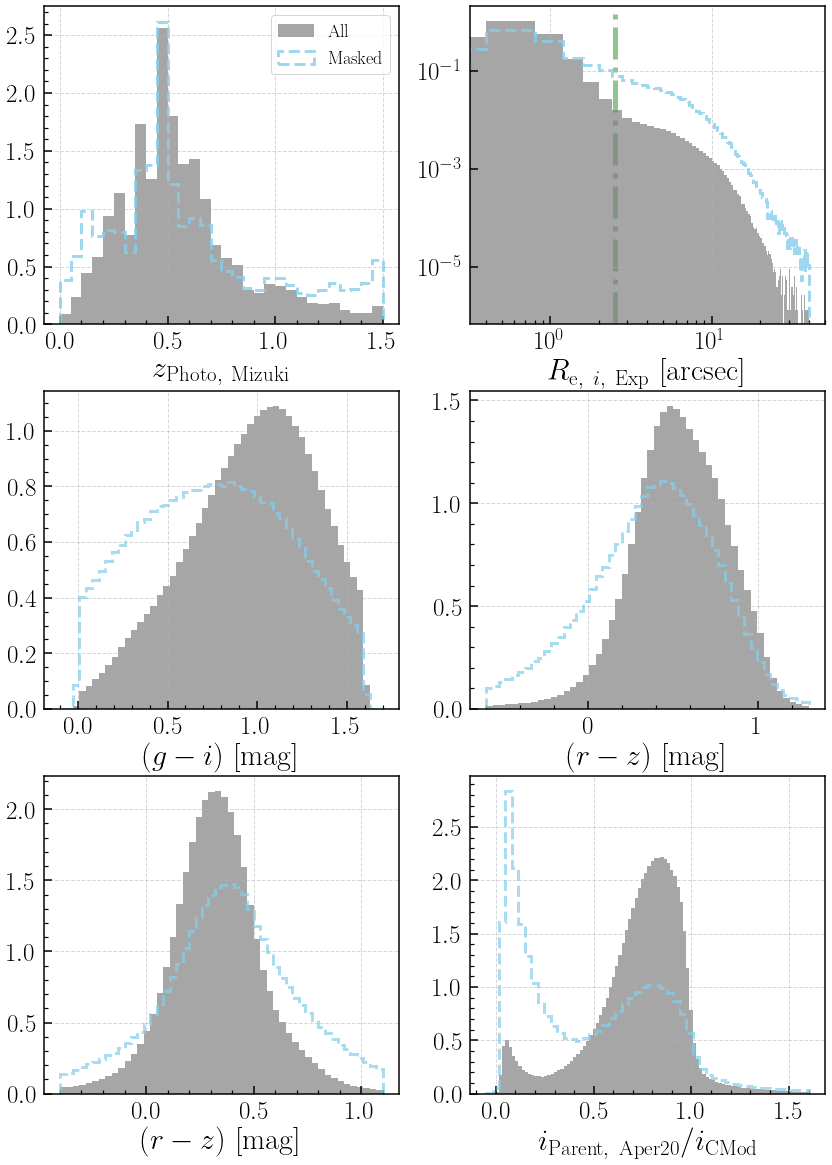

In [59]:
fig, axs = plt.subplots(3, 2, figsize=(14, 20))
plt.subplots_adjust(hspace=0.21)


# Photo-z
ax1 = axs[0, 0]
_ = ax1.hist(pdr2_g09_bsm['photoz_best'][mask], range=(0, 1.5), bins=30, histtype='stepfilled', 
             color='grey', linewidth=1, alpha=0.7, label=r'$\rm All$', density=True)

_ = ax1.hist(pdr2_g09_msk['photoz_best'], range=(0, 1.5), bins=30, histtype='step', 
             color='skyblue', linewidth=3, linestyle='--', alpha=0.8, label=r'$\rm Masked$', density=True)

#_ = ax1.hist(pdr2_match_bsm['photoz_best'], range=(0, 1.5), bins=30, histtype='step', 
#             color='orangered', linewidth=5, linestyle='-', alpha=0.8, label=r'$\rm Dwarf$', density=True)


ax1.legend(fontsize=18)

_ = ax1.set_xlabel(r'$z_{\rm Photo,\ Mizuki}$', fontsize=30)

# CModel, exponential size

ax2 = axs[0, 1]
ax2.loglog()

_ = ax2.hist(pdr2_g09_bsm['i_cmodel_exp_ellipse_r'][mask], range=(0, 40), bins=100, histtype='stepfilled', 
             color='grey', linewidth=1, alpha=0.7, label=r'$\rm All$', density=True)

_ = ax2.hist(pdr2_g09_msk['i_cmodel_exp_ellipse_r'], range=(0, 40), bins=100, histtype='step', 
             color='skyblue', linewidth=3, linestyle='--', alpha=0.8, label=r'$\rm All$', density=True)

#_ = ax2.hist(pdr2_match_bsm['i_cmodel_exp_ellipse_r'], range=(0, 15), bins=40, histtype='step', 
#             color='orangered', linewidth=5, linestyle='-', alpha=0.8, label=r'$\rm Dwarf$', density=True)

_ = ax2.set_xlabel(r'$R_{{\rm e},\ i,\ \rm Exp}\ [\rm arcsec]$', fontsize=30)
_ = ax2.axvline(2.5, linestyle='-.', c='forestgreen', linewidth=5, alpha=0.5, zorder=0)


# CModel (g-i) color
ax3 = axs[1, 0]

_ = ax3.hist(pdr2_g09_bsm['g_cmodel_mag'][mask] - pdr2_g09_bsm['i_cmodel_mag'][mask], 
             range=(-0.1, 1.7), bins=50, histtype='stepfilled', 
             color='grey', linewidth=1, alpha=0.7, label=r'$\rm All$', density=True)

_ = ax3.hist(pdr2_g09_msk['g_cmodel_mag'] - pdr2_g09_msk['i_cmodel_mag'], 
             range=(-0.1, 1.7), bins=50, histtype='step', 
             color='skyblue', linewidth=3, linestyle='--', alpha=0.7, label=r'$\rm All$', density=True)

#_ = ax3.hist(pdr2_match_bsm['g_cmodel_mag'] - pdr2_match_bsm['i_cmodel_mag'], 
#             range=(-0.1, 1.7), bins=32, histtype='step', 
#             color='orangered', linewidth=5, linestyle='-', alpha=0.8, label=r'$\rm Dwarf$', density=True)

_ = ax3.set_xlabel(r'$(g-i)\ [\rm mag]$', fontsize=30)

# CModel (r-z) color
ax4 = axs[1, 1]

_ = ax4.hist(pdr2_g09_bsm['r_cmodel_mag'][mask] - pdr2_g09_bsm['z_cmodel_mag'][mask], 
             range=(-0.6, 1.3), bins=50, histtype='stepfilled', 
             color='grey', linewidth=1, alpha=0.7, label=r'$\rm All$', density=True)

_ = ax4.hist(pdr2_g09_msk['r_cmodel_mag'] - pdr2_g09_msk['z_cmodel_mag'], 
             range=(-0.6, 1.3), bins=50, histtype='step', 
             color='skyblue', linewidth=3, linestyle='--', alpha=0.7, label=r'$\rm All$', density=True)

#_ = ax4.hist(pdr2_match_bsm['r_cmodel_mag'] - pdr2_match_bsm['z_cmodel_mag'], 
#             range=(-0.6, 1.3), bins=32, histtype='step', 
#             color='orangered', linewidth=5, linestyle='-', alpha=0.8, label=r'$\rm Dwarf$', density=True)

_ = ax4.set_xlabel(r'$(r-z)\ [\rm mag]$', fontsize=30)

# CModel (i-y) color
ax5 = axs[2, 0]

_ = ax5.hist(pdr2_g09_bsm['i_cmodel_mag'][mask] - pdr2_g09_bsm['y_cmodel_mag'][mask], 
             range=(-0.4, 1.1), bins=50, histtype='stepfilled', 
             color='grey', linewidth=1, alpha=0.7, label=r'$\rm All$', density=True)

_ = ax5.hist(pdr2_g09_msk['i_cmodel_mag'] - pdr2_g09_msk['y_cmodel_mag'], 
             range=(-0.4, 1.1), bins=50, histtype='step', 
             color='skyblue', linewidth=3, linestyle='--', alpha=0.7, label=r'$\rm All$', density=True)

#_ = ax5.hist(pdr2_match_bsm['i_cmodel_mag'] - pdr2_match_bsm['y_cmodel_mag'], 
#             range=(-0.4, 1.1), bins=32, histtype='step', 
#             color='orangered', linewidth=5, linestyle='-', alpha=0.8, label=r'$\rm Dwarf$', density=True)

_ = ax5.set_xlabel(r'$(r-z)\ [\rm mag]$', fontsize=30)


# Ratio between aperture and CModel flux
ax6 = axs[2, 1]
#ax6.loglog()

_ = ax6.hist(pdr2_g09_bsm['i_undeblended_convolvedflux_3_20_flux'][mask] / pdr2_g09_bsm['i_cmodel_flux'][mask], 
             range=(-0.05, 1.6), bins=100, histtype='stepfilled', 
             color='grey', linewidth=1, alpha=0.7, label=r'$\rm All$', density=True)

_ = ax6.hist(pdr2_g09_msk['i_undeblended_convolvedflux_3_20_flux'] / pdr2_g09_msk['i_cmodel_flux'],
             range=(-0.05, 1.6), bins=50, histtype='step', 
             color='skyblue', linewidth=3, linestyle='--', alpha=0.7, label=r'$\rm All$', density=True)

#_ = ax6.hist(pdr2_match_bsm['i_undeblended_convolvedflux_3_20_flux'] / pdr2_match_bsm['i_cmodel_flux'],
#             range=(-0.05, 1.6), bins=30, histtype='step', 
#             color='orangered', linewidth=5, linestyle='-', alpha=0.8, label=r'$\rm Dwarf$', density=True)

_ = ax6.set_xlabel(r'$i_{\rm Parent,\ Aper20}/i_{\rm CMod}$', fontsize=30)

In [17]:
large_flag = np.log10(cat_g09['i_cmodel_exp_ellipse_r']) >= 0.5
small_flag = (np.log10(cat_g09['i_cmodel_exp_ellipse_r']) <= -0.8) & (cat_g09['i_cmodel_mag'] <= 22.0)

large_flag.sum(), small_flag.sum()

(72354, 6556)

In [79]:
sample_1 = cat_g09[~large_flag]
sample_2 = cat_g09[large_flag]
sample_3 = cat_g09[small_flag]

In [80]:
random_1 = Table(np.random.choice(sample_1, 200, replace=False))
random_2 = Table(np.random.choice(sample_2, 100, replace=False))
random_3 = Table(np.random.choice(sample_3, 100, replace=False))

<ipython-input-85-b2f489035bdf>:3: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.hexbin(cat_g09['i_cmodel_mag'], np.log10(cat_g09['i_cmodel_exp_ellipse_r']),


Text(0, 0.5, '$\\log\\ (R_{\\rm CMod,\\ Exp,\\ i}/[\\rm arcsec])$')

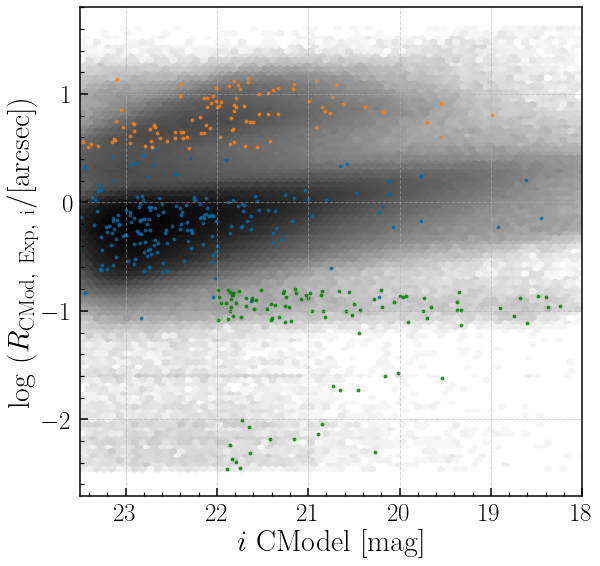

In [85]:
plt.figure(figsize=(9, 9))

plt.hexbin(cat_g09['i_cmodel_mag'], np.log10(cat_g09['i_cmodel_exp_ellipse_r']), 
           extent=(17.5, 24.2, -2.5, 1.6), vmin=1, cmap='Greys', bins='log', gridsize=(80, 50))

plt.scatter(random_1['i_cmodel_mag'], np.log10(random_1['i_cmodel_exp_ellipse_r']), s=8, alpha=0.8)
plt.scatter(random_2['i_cmodel_mag'], np.log10(random_2['i_cmodel_exp_ellipse_r']), s=8, alpha=0.8)
plt.scatter(random_3['i_cmodel_mag'], np.log10(random_3['i_cmodel_exp_ellipse_r']), s=8, alpha=0.8, c='g')

plt.xlim(23.5, 18.0)

plt.xlabel(r'$i\ \rm CModel\ [mag]$', fontsize=30)
plt.ylabel(r'$\log\ (R_{\rm CMod,\ Exp,\ i}/[\rm arcsec])$', fontsize=30)

In [117]:
def show_obj(obj, archive=pdr2):
    """Show 3-Color picture"""
    coord = SkyCoord(obj['ra'], obj['dec'], unit='deg')
    
    # Angular size
    s_ang = 10.0 * obj['i_cmodel_exp_ellipse_r']
    s_ang = s_ang if s_ang <= 20 else 20
    s_ang = s_ang if s_ang >= 3 else 3

    cutout_rgb, cutout_wcs = hsc_tricolor(
        coord, cutout_size=s_ang, filters='gri', verbose=False, 
        save_rgb=False, save_img=False, use_saved=False, archive=pdr2)
    
    return plotting.display_single(cutout_rgb)

In [122]:
random_1.write(os.path.join(merian_dir, 'catalog', 'random_1', 'random_1.fits'), overwrite=True)

for ii, obj in enumerate(random_1):    
    fig = show_obj(obj)
    fig.savefig(
        os.path.join(merian_dir, 'catalog', 'random_1', 'random_1_obj_{:d}.png'.format(ii + 1)))
    plt.close(fig)

In [123]:
random_2.write(os.path.join(merian_dir, 'catalog', 'random_2', 'random_2.fits'), overwrite=True)

for ii, obj in enumerate(random_2):    
    fig = show_obj(obj)
    fig.savefig(
        os.path.join(merian_dir, 'catalog', 'random_2', 'random_2_obj_{:d}.png'.format(ii + 1)))
    plt.close(fig)

In [124]:
random_3.write(os.path.join(merian_dir, 'catalog', 'random_3', 'random_3.fits'), overwrite=True)

for ii, obj in enumerate(random_3):    
    fig = show_obj(obj)
    fig.savefig(
        os.path.join(merian_dir, 'catalog', 'random_3', 'random_3_obj_{:d}.png'.format(ii + 1)))
    plt.close(fig)
